## Install Prerequisites

In [1]:
!pip install --upgrade pip
!pip install ipywidgets pyyaml plotly networkx networkx matplotlib scipy
!jupyter nbextension enable --py widgetsnbextension
!jupyter labextension install @jupyter-widgets/jupyterlab-manager
!jupyter lab build

     |████████████████████████████████| 1.5 MB 1.1 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.3.1
    Uninstalling pip-20.3.1:
      Successfully uninstalled pip-20.3.1
     |████████████████████████████████| 121 kB 637 kB/s eta 0:00:01
     |████████████████████████████████| 662 kB 541 kB/s eta 0:00:01
     |████████████████████████████████| 20.6 MB 1.2 MB/s eta 0:00:01    |██████████████▊                 | 9.5 MB 549 kB/s eta 0:00:21
     |████████████████████████████████| 1.9 MB 768 kB/s eta 0:00:01
     |████████████████████████████████| 10.3 MB 834 kB/s eta 0:00:01
     |████████████████████████████████| 28.4 MB 1.1 MB/s eta 0:00:01     |█████████████▍                  | 11.8 MB 295 kB/s eta 0:00:56
     |████████████████████████████████| 2.2 MB 952 kB/s eta 0:00:01
     |████████████████████████████████| 243 kB 959 kB/s eta 0:00:01
     |████████████████████████████████| 10.6 MB 594 kB/s eta 0:00:01
     |████████████████████████████████|

In [2]:
import subprocess
import sys
import base64
import getpass
import requests
import yaml
import matplotlib
import plotly.graph_objects as go
import networkx as nx
import webbrowser

To be able to show the whigets run:
```
pip install --upgrade pip
pip install ipywidgets ipywidgets pyyaml plotly networkx networkx
!jupyter nbextension enable --py widgetsnbextension
jupyter nbextension enable --py widgetsnbextension
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter lab build
```
Close the Jupyter lab window and open it again 

# Client Configuration

In [3]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from ipywidgets import TwoByTwoLayout
from ipywidgets import AppLayout, Button, Layout


sdia_conf_url_widget =  widgets.Text(
    value='https://lifewatch.lab.uvalight.net:30003/orchestrator',
    placeholder='Enter SDIA API endpoint. e.g. https://lifewatch.lab.uvalight.net:30003/orchestrator',
    description='SDIA API URL:',
    disabled=False
)
sdia_conf_username_widget =  widgets.Text(
    value='notebook_user',
    placeholder='Enter SDIA username',
    description='SDIA username:',
    disabled=False
)

sdia_conf_token_widget =  widgets.Password(
    value='',
    placeholder='Enter your SDIA token',
    description='Password:',
    disabled=False
) 

sdia_conf_login_button = widgets.Button(
    description='Login',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Run report',
#     icon='check' # (FontAwesome names without the `fa-` prefix)
)

sdia_conf_output = widgets.Output()
sdia_conf_box = widgets.VBox([sdia_conf_url_widget, sdia_conf_username_widget, sdia_conf_token_widget, sdia_conf_login_button])
display(sdia_conf_box,sdia_conf_output)


Output()

# Application Configuration

In [4]:
application_type_widget = widgets.Dropdown(
    options=['Helm'],
    value='Helm',
    description='Application Type:',
    disabled=False
)

application_type_output = widgets.Output()
application_type_box = widgets.VBox([application_type_widget])
display(application_type_box,application_type_output)

Output()

In [5]:
docker_app_image_name_widget =  widgets.Textarea(
    value='cloudcells/classifiers',
    placeholder='image name e.g. cloudcells/classifiers',
    description='Docker Image Name:',
    disabled=False
)

docker_app_image_ports_widget =  widgets.Textarea(
    value='',
    placeholder='the ports to expose e.g. 80',
    description='Ports:',
    disabled=False
)

enebale_monitoring_widget= widgets.Checkbox(
    value=True,
    description='Monitoring',
    disabled=False
)

app_name_widget =  widgets.Text(
    value='argowf',
    placeholder='the applications name',
    description='Application Name:',
    disabled=False
)

docker_app_box = widgets.VBox([app_name_widget,docker_app_image_name_widget, docker_app_image_ports_widget,enebale_monitoring_widget])

                    
helm_app_chart_name_widget =  widgets.Text(
    value='argo/argo-workflows',
    placeholder='the chart name e.g. argo/argo',
    description='Chart Name:',
    disabled=False
)


helm_app_repo_name_widget =  widgets.Text(
    value='argo',
    placeholder='the name of the repoitory name',
    description='Reposetory Name:',
    disabled=False
)

helm_app_repo_url_widget =  widgets.Text(
    value='https://argoproj.github.io/argo-helm',
    placeholder='the url',
    description='Reposetory URL:',
    disabled=False
)

helm_app_values =  widgets.Text(
    value='server.serviceType=NodePort',
    placeholder='helm values',
    description='helm values',
    disabled=False
)

helm_app_box = widgets.VBox([app_name_widget,helm_app_chart_name_widget, helm_app_repo_name_widget,helm_app_repo_url_widget,helm_app_values,enebale_monitoring_widget])

app_conf_output = widgets.Output()

if application_type_widget.value == 'Docker':
    display(docker_app_box,app_conf_output)
elif application_type_widget.value == 'Helm':
    display(helm_app_box,app_conf_output)


Output()

# Infrastructure Configuration

## Number of Topologies
A topology is a set of VMs that will be provisined in the same location by the same provider.

In [6]:
num_of_topologies_widget= widgets.BoundedIntText(
    value=1,
    min=1,
    max=4,
    step=1,
    description='Num. Of Topologies:',
    disabled=False
)


topologies_output = widgets.Output()
number_of_topology_box = widgets.VBox([num_of_topologies_widget])
display(number_of_topology_box,topologies_output)


Output()

In [9]:
topologies_boxes = []
domain_names = ['East US','Central US','South Central US','West US','Australia East','Southeast Asia','UK South','West Europe','North Europe','South Africa North','Central India']


for i in range(0, num_of_topologies_widget.value):
    cloud_provider_name_widget = widgets.Dropdown(
        options=['EC2', 'Azure'],
        value='Azure',
        description='Cloud Provider:',
        name='cloud_provider_name',
        disabled=False
    )
    
    num_of_vms_widget= widgets.BoundedIntText(
        value=1,
        min=1,
        max=4,
        step=1,
        description='Num. Of VMs:',
        disabled=False
    )
    vm_size_name_widget = widgets.Dropdown(
        options=['small', 'medium','large','large_mem'],
        value='large_mem',
        description='VM size:',
        disabled=False
    )
    topology_domain_widget = widgets.Dropdown(
        options=domain_names,
        value=domain_names[7],
        description='Topology Domain:',
        disabled=False
    )
    topology_box = widgets.VBox([cloud_provider_name_widget, num_of_vms_widget, vm_size_name_widget,topology_domain_widget])
    topologies_boxes.append(topology_box)

    
    
topologies_conf_tab = widgets.Tab()
topologies_conf_tab.children = topologies_boxes
for i in range(len(topologies_boxes)):
    topologies_conf_tab.set_title(i, 'topology_'+str(i+1))
    
    
topologies_conf_output = widgets.Output()
topologies_conf_tab_box = widgets.VBox([topologies_conf_tab])
display(topologies_conf_tab_box,topologies_conf_output)

Output()

## Generate TOSCA

In [22]:
import requests


def get_template(url):
    r = requests.get(url)
    with open('interface.yaml', 'wb') as f:
        f.write(r.content)

    with open('interface.yaml') as f:
        interface = yaml.safe_load(f)
    return interface
    
node_templates={}
app_prop = []

if application_type_widget.value == 'Docker':
    app_prop.append('Image Name: '+docker_app_image_name_widget.value)
    app_prop.append('Ports: '+docker_app_image_ports_widget.value)
elif application_type_widget.value == 'Helm':
    app_prop.append('Application Type: '+application_type_widget.value)
    app_prop.append('Chart name: '+helm_app_chart_name_widget.value)
    app_prop.append('Reposetory name: '+helm_app_repo_name_widget.value)
    app_prop.append('Reposetory URL: '+helm_app_repo_url_widget.value)

text = 'Application\n'
for line in app_prop:
    text += line+'\n'
    

def build_node_template(node_name=None,node_type=None,properties=None,requirements=None,interfaces=None):
    node_template = {node_name:{'properties':properties,'requirements':requirements,'interfaces':interfaces,'type':node_type}}
    return node_template
    
def translate_domain(cloud_provider,domain_name):
    if cloud_provider == 'Azure':
        return domain_name.lower().replace(' ','')
    
    
def translate_vm_size(cloud_provider,vm_size):
    vm_specs = {}
    if vm_size == 'small':
        vm_specs['num_cores']='1'
        vm_specs['mem_size']='2048 MB'
        vm_specs['disk_size']='10000 MB'
    elif vm_size == 'medium':
        vm_specs['num_cores']='2'
        vm_specs['mem_size']='4048 MB'
        vm_specs['disk_size']='20000 MB'
    elif vm_size == 'large':
        vm_specs['num_cores']='4'
        vm_specs['mem_size']='8048 MB'
        vm_specs['disk_size']='40000 MB'
    elif vm_size == 'large_mem':
        vm_specs['num_cores']='4'
        vm_specs['mem_size']='256000 MB'
        vm_specs['disk_size']='40000 MB'
    return vm_specs
    Generate
    
text += '\nInfrastructure\n'

def repalce_all(d,dict_value,value):
    for k, v in d.items():
        if isinstance(v, dict):
            repalce_all(v,dict_value,value)
        else:
            if v==dict_value:
                v = value
            if isinstance(v, list):
                v = [value if i==dict_value else i for i in v]

## Methods

In [32]:
def get_topology_info(topology_wiget_children, topology_num):
    topology_info={}
    topology_info['name'] = 'topology_'+str(index)
    
    for child in topology.children:
        topology_info[child.description.replace(':','').replace(' ','_')]=child.value
    return topology_info

def get_vm_info(topology_info):
    vm_name = 'compute_'+str(i)+'_'+topology_info['name']
    vm_properties = {'os_distro': 'Ubuntu','os_version':'18.04','user_name': 'vm_user'}
    vm_properties.update(translate_vm_size(topology_properties['provider'],topology_info['VM_size']))
    vm_interfaces={'Standard':{'create':'dumy.yaml'}}
    
    vm_info={'name':vm_name,'properties':vm_properties,'interfaces':vm_interfaces,'type':'tosca.nodes.QC.VM.Compute'}
    return vm_info
        
    
def get_instance_properties(vm_name):
    instance_props = {}
    for prop_name in ['user_name','user_name','os_version','disk_size','mem_size','num_cores','os_distro']:
        instance_props[prop_name] = { 'get_property': [vm_name, prop_name ] }
    return instance_props

def get_k8s_inventory(k8s_interface,count):
    for interface_action_name in k8s_interface['Kubernetes']:
        inv_children = k8s_interface['Kubernetes'][interface_action_name]['inputs']['inventory']['all']['children']['cluster']['children']
        props={}
        props['ansible_host'] = { 'get_attribute': [ vm_info['name'],'public_ip' ] }
        props['ansible_python_interpreter'] = '/usr/bin/python3'
        props['ansible_ssh_user'] = { 'get_property': [ vm_info['name'],'user_name' ] }
        if count <=0:
            inv_children['master']['hosts']['m_0'] = props
        elif 'worker' in inv_children:
            host={'w_'+str(count):props}
            inv_children['worker']['hosts']= host
            
def get_azure_topology_interface(instances):
    azure_topology_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_topology_interface.yaml')
    azure_topology_interface = yaml.safe_load(yaml.dump(azure_topology_interface).replace('TOPOLOGY_NAME',topology_info['name']))    
    for interface_action_name in azure_topology_interface['Azure']:
        if 'instances' in azure_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts']['localhost']:
            azure_topology_interface['Azure'][interface_action_name]['inputs']['inventory']['all']['hosts']['localhost']['instances'] = instances
    return azure_topology_interface

def get_azure_workflows():
    wfs = {}
    azure_workflows = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/azure_prov_workflow.yaml')
    for workflow_name in azure_workflows:
        for step_name in azure_workflows[workflow_name]['steps']:
            azure_workflows[workflow_name]['steps'][step_name]['target'] = topology_info['name']
        if 'preconditions' in azure_workflows[workflow_name]:
            for preconditions in azure_workflows[workflow_name]['preconditions']:
                preconditions['target'] = topology_info['name']
        wf = {workflow_name+'_'+topology_info['name']:azure_workflows[workflow_name]}
        wfs.update(wf)
    return wfs


def get_k8s_workflows(topology_names,enebale_monitoring,helm_app_name):
    wfs = {}
    if enebale_monitoring:          
        k8s_workflows = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_workflow_heml_monitoring.yaml')
    else:
        k8s_workflows = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_workflow.yaml')
        
    k8s_workflows = yaml.safe_load(yaml.dump(k8s_workflows).replace('KUBERNETES_NAME','kubernetes').replace('HELM_NAME',helm_app_name))
    topology_preconditions = []
    
    for topology_name in topology_names:
        precondition = {'condition': [{'assert': [{'current_state': [{'equal': 'RUNNING'}]}]}],
                        'target': 'TOPOLOGY_NAME'}
        precondition['target'] = topology_name
        topology_preconditions.append(precondition)
    
    
    for workflow_name in k8s_workflows:
        print('Adding '+workflow_name)
        if 'preconditions' in k8s_workflows[workflow_name]:
            index = 0
            topology_precondition_indexes = []
            for precondition in k8s_workflows[workflow_name]['preconditions']:
                if precondition['target'] == 'TOPOLOGY_NAME':
                    topology_precondition_indexes.append(index)
                index+=1
            for topology_precondition_index in topology_precondition_indexes:
                print('Removing: '+str(k8s_workflows[workflow_name]['preconditions'][topology_precondition_index]) + ' from: '+workflow_name)
                del k8s_workflows[workflow_name]['preconditions'][topology_precondition_index]
                
        for topology_precondition in topology_preconditions:
            print('Adding '+str(topology_precondition) + ' to: '+workflow_name)
            k8s_workflows[workflow_name]['preconditions'].append(topology_precondition)
        wf = {workflow_name: k8s_workflows[workflow_name]}
        wfs.update(wf)
    return wfs

def get_helm_workflow(app_name,workflow):
    wfs = {}        
    workflow = yaml.safe_load(yaml.dump(workflow).replace('HELM_NAME',app_name))
    for workflow_name in workflow:
        wf = {workflow_name+'_'+app_name:helm_workflow[workflow_name]}
        wfs.update(wf)
    return wfs
        

    
def get_helm_monitoring_info():
    helm_monitoring_info={}
    helm_req = {'kubernetes':{'capability': 'tosca.capabilities.QC.Kubernetes','node':'kubernetes' ,'relationship':'tosca.relationships.HostedOn'}}
    helm_requirements = []
    helm_requirements.append(helm_req)
    helm_monitoring_info['requirements'] = helm_requirements
    
    monitoring_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_interface.yaml')

    ansible_vars = {}
    ansible_vars['ansible_host']={ 'get_attribute': [ vm_master_name,'public_ip' ] }
    ansible_vars['ansible_python_interpreter']= '/usr/bin/python3'
    ansible_vars['ansible_ssh_user']= { 'get_property': [ vm_master_name,'user_name' ] }

    for interface_action_name in monitoring_interface['Helm']:
        monitoring_interface['Helm'][interface_action_name]['inputs']['inventory']['all']['hosts']['master'] = ansible_vars
        
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['chart_name'] = 'prometheus-community/kube-prometheus-stack'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_name'] = 'prometheus-community'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_url'] =  'https://prometheus-community.github.io/helm-charts'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['helm_name'] = 'monitoring'
    monitoring_interface['Helm']['install_chart']['inputs']['extra_variables']['values'] = {'grafana': {'service':{'type':'NodePort'}}}
    
    helm_monitoring_info['interfaces'] = monitoring_interface
    
    helm_monitoring_info['name'] = 'monitoring'
    return helm_monitoring_info


def get_helm_app_info(chart_name,repo_name,repo_url, app_name,helm_app_values):
    helm_app_info = {}
    helm_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/helm_interface.yaml')
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['chart_name'] = helm_app_chart_name_widget.value
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_name'] = helm_app_repo_name_widget.value
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['repo_url'] = helm_app_repo_url_widget.value
    helm_interface['Helm']['install_chart']['inputs']['extra_variables']['helm_name'] = app_name_widget.value
    
    ansible_vars = {}
    ansible_vars['ansible_host']={ 'get_attribute': [ vm_master_name,'public_ip' ] }
    ansible_vars['ansible_python_interpreter']= '/usr/bin/python3'
    ansible_vars['ansible_ssh_user']= { 'get_property': [ vm_master_name,'user_name' ] }

    for interface_action_name in helm_interface['Helm']:
        helm_interface['Helm'][interface_action_name]['inputs']['inventory']['all']['hosts']['master'] = ansible_vars
    
    helm_req = {'kubernetes':{'capability': 'tosca.capabilities.QC.Kubernetes','node':'kubernetes' ,'relationship':'tosca.relationships.HostedOn'}}
    helm_requirements = []
    helm_requirements.append(helm_req)    
    helm_app_info['requirements'] = helm_requirements
    helm_app_info['interfaces'] = helm_interface
    helm_app_info['name'] = app_name
    
    helm_dict_value = {}
    if helm_app_values:
        helm_dict_value.update(parse_helm_values(helm_app_values))
    if chart_name == 'argo/argo-workflows':
        container_runtime_executor_val = {}
        container_runtime_executor_val['containerRuntimeExecutor'] = 'k8sapi'
        helm_dict_value.update(container_runtime_executor_val)
    
    if helm_dict_value:
        helm_interface['Helm']['install_chart']['inputs']['extra_variables']['values'] = helm_dict_value
        print(helm_interface['Helm']['install_chart']['inputs']['extra_variables']['values'])
    return helm_app_info

In [33]:
index=0
node_templates = {}

k8s_interface = get_template('https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/develop/templates/k8s_interface.yaml')
k8_requirements=[]
workflows = {}
    
topology_names=[]
for topology in topologies_boxes:
    index+=1
    
    topology_info = get_topology_info(topology.children,index)
    topology_names.append(topology_info['name'])
    
    topology_properties={}
    topology_properties['domain']=translate_domain(topology_info['Cloud_Provider'],topology_info['Topology_Domain'])
    topology_properties['provider'] = topology_info['Cloud_Provider']
    topology_requirements=[]
    instances = {}
    
    for i in range(topology_info['Num._Of_VMs']):
        vm_info = get_vm_info(topology_info)
        node_templates.update(build_node_template(node_name=vm_info['name'],node_type=vm_info['type'],properties=vm_info['properties'],interfaces=vm_info['interfaces']))
        vm_req={'vm':{'capability': 'tosca.capabilities.QC.VM','node':vm_info['name'] ,'relationship':'tosca.relationships.DependsOn'}}
        topology_requirements.append(vm_req)  
        instance_props =  get_instance_properties(vm_info['name'])
        instances[vm_info['name']] = instance_props
        inv_children = get_k8s_inventory(k8s_interface,i)

                
    azure_topology_interface = get_azure_topology_interface(instances)
            
    azure_workflows = get_azure_workflows()
    workflows.update(azure_workflows)
    
k8s_workflows = get_k8s_workflows(topology_names,enebale_monitoring_widget.value,app_name_widget.value)
workflows.update(k8s_workflows)
                
k8_requirement={'host':{'capability': 'tosca.capabilities.QC.VM.topology','node':topology_info['name'] ,'relationship':'tosca.relationships.HostedOn'}}
k8_requirements.append(k8_requirement)
node_templates.update(build_node_template(node_name=topology_info['name'],node_type='tosca.nodes.QC.VM.topology',properties=topology_properties,requirements=topology_requirements,interfaces=azure_topology_interface))
    

Adding template_wf_deploy_k8s
Removing: {'condition': [{'assert': [{'current_state': [{'equal': 'RUNNING'}]}]}], 'target': 'TOPOLOGY_NAME'} from: template_wf_deploy_k8s
Adding {'condition': [{'assert': [{'current_state': [{'equal': 'RUNNING'}]}]}], 'target': 'topology_1'} to: template_wf_deploy_k8s


In [34]:
vm_master_name = 'compute_'+str(0)+'_'+topology_info['name']
credential_properties = {'credential': { 'get_attribute': [ vm_master_name,'user_key_pair' ] }}        
ks8s_node = build_node_template(node_name='kubernetes',node_type='tosca.nodes.QC.docker.Orchestrator.Kubernetes',
                                properties=credential_properties,requirements=k8_requirements,interfaces=k8s_interface)
node_templates.update(ks8s_node)

In [35]:
import json 

def parse_helm_values(helm_values):
    str_dict = '{\"'
    for item in helm_values.split("."):
        if '=' not in item:
            str_dict+=item+'\":{'
        if '=' in item:
            str_dict+='\"'+item.split("=")[0]+'\":\"'+item.split("=")[1]+'\"}}'
    return json.loads(str_dict)



if enebale_monitoring_widget.value:
    helm_monitoring_info = get_helm_monitoring_info()
    node_templates.update(build_node_template(node_name=helm_monitoring_info['name'],node_type='tosca.nodes.QC.Container.Application.Helm',
                                                  properties=credential_properties,requirements=helm_monitoring_info['requirements'],
                                              interfaces=helm_monitoring_info['interfaces']))
    

    
helm_app_info = get_helm_app_info(helm_app_chart_name_widget.value, helm_app_repo_name_widget.value, 
                                  helm_app_repo_url_widget.value,app_name_widget.value,helm_app_values.value)

            
node_templates.update(build_node_template(node_name=helm_app_info['name'],
                                          node_type='tosca.nodes.QC.Container.Application.Helm',
                                          properties=credential_properties,
                                          requirements=helm_app_info['requirements'],
                                          interfaces=helm_app_info['interfaces']))

NameError: name 'container_runtime_executor_val' is not defined

In [27]:
import os

topology_template={}
topology_template['node_templates'] = node_templates
topology_template['workflows'] = workflows
tosca = {}
tosca['tosca_definitions_version'] = 'tosca_simple_yaml_1_2'
imports=[{'nodes':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/nodes.yaml','data':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/data.yml','capabilities':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/capabilities.yaml','policies':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/policies.yaml','interfaces':'https://raw.githubusercontent.com/qcdis-sdia/sdia-tosca/master/types/interfaces.yml'}]
tosca['imports'] = imports
repositories = {'docker_hub':'https://hub.docker.com/'}
tosca['repositories'] = repositories
tosca['topology_template'] = topology_template

class NoAliasDumper(yaml.Dumper):
    def ignore_aliases(self, data):
        return True
    

filePath = 'generated_tosca.yaml';
if os.path.exists(filePath):
    os.remove(filePath)
    
with open(filePath, 'w') as file:
    yaml.dump(tosca, file,default_flow_style=False,Dumper=NoAliasDumper)

## Upload TOSCA

In [17]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

base_url = sdia_conf_url_widget.value
username = sdia_conf_username_widget.value
password = sdia_conf_token_widget.value

path = "/tosca_template"
payload = {}
filename = 'generated_tosca.yaml'
fin = open(filename, 'rb')
files = {'file': fin}

headers = {}

response = requests.request("POST", base_url+path, headers=headers, files = files,verify=False,auth=(username, password))
tosca_id = response.text

## Show Topology

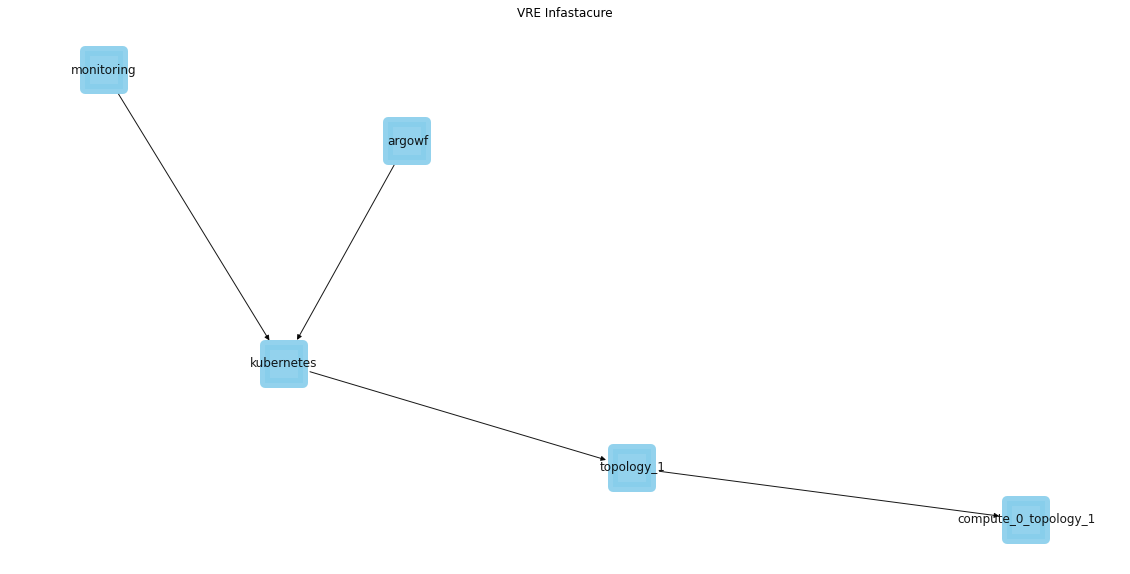

In [18]:
import networkx as nx
import random
import matplotlib.pyplot as plt



def build_graph(node_templates):
    graph = nx.DiGraph()
    for node_name in node_templates:
        graph.add_node(node_name, attr_dict=node_templates[node_name])
        if 'requirements' in node_templates[node_name]:
            for req in node_templates[node_name]['requirements']:
                req_name = next(iter(req))
                req_node_name = req[req_name]['node']
                if 'relationship' in req[req_name] and 'type' in req[req_name]['relationship']:
                    relationship_type = req[req_name]['relationship']['type']
                else:
                    if 'relationship' not in req[req_name]:
                        relationship_type = 'tosca.relationships.DependsOn'
                    else:
                        relationship_type = req[req_name]['relationship']
                graph.add_edge(node_name, req_node_name, relationship=relationship_type)

    # nx.draw(graph, with_labels=True)
    # plt.savefig("/tmp/graph.png")
    # plt.show()
    return graph




def get_tosca(tosca_id):
    path = "/tosca_template/"+tosca_id
    payload = {}
    headers= {'accept':'text/plain'}
    response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
    return response.text

tosca = get_tosca(tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
# nx.draw(graph, with_labels=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 10));
# nx.draw_networkx(graph, ax=ax,node_size=5000, node_color='#00b4d9')


nx.draw(graph, with_labels=True, node_size=1500, node_color="skyblue", node_shape="s", alpha=0.9, linewidths=10,pos=nx.spring_layout(graph))
plt.title("VRE Infastacure")
plt.show()





## Provision Plan

In [19]:
path = "/provisioner/provision/"+tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload,verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
provisioned_tosca_id = response.text

vm : compute_0_topology_1 is running at: 20.101.69.197
topology_1 current_state: RUNNING


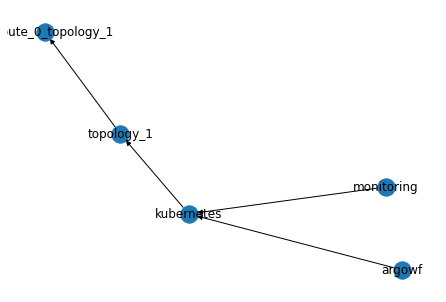

In [20]:
# print(provisioned_tosca_id)
tosca = get_tosca(provisioned_tosca_id)
tosca_dict = yaml.safe_load(tosca)
graph = build_graph(tosca_dict['topology_template']['node_templates'])
nx.draw(graph, with_labels=True)


for node_name in tosca_dict['topology_template']['node_templates']:
    if 'attributes' in tosca_dict['topology_template']['node_templates'][node_name] and 'public_ip' in tosca_dict['topology_template']['node_templates'][node_name]['attributes']:
        print('vm : '+node_name +' is running at: '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['public_ip'])
    if 'attributes' in tosca_dict['topology_template']['node_templates'][node_name] and 'current_state' in tosca_dict['topology_template']['node_templates'][node_name]['attributes']:
        print(node_name+' current_state: '+tosca_dict['topology_template']['node_templates'][node_name]['attributes']['current_state'])

        
    
        

## Deploy K8s And Helm Apps

In [21]:
path = "/deployer/deploy/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("GET", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
deployed_tosca_id = response.text

KeyboardInterrupt: 

In [502]:
import urllib.request
import ssl
import urllib.request

tosca = get_tosca(deployed_tosca_id)
tosca_dict = yaml.safe_load(tosca)


ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE


services = {}

for node_name in tosca_dict['topology_template']['node_templates']:
    if tosca_dict['topology_template']['node_templates'][node_name]['type'] == 'tosca.nodes.QC.docker.Orchestrator.Kubernetes':
        for token in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['tokens']:
            if token['token_type'] == 'k8s_dashboard_token':
                dashboard_token = token['token']
        for service_url in tosca_dict['topology_template']['node_templates'][node_name]['attributes']['service_urls']:
                fp = urllib.request.urlopen(service_url, context=ctx)
                contents_bytes = fp.read()
                contents = contents_bytes.decode("utf8")
                fp.close()
                if '<title>Grafana</title>' in contents:
                    services['grafana'] = {'url':service_url}
                elif '<title>Argo</title>' in contents:
                    services['argo_dashboard'] = {'url':service_url}
                else:
                    services['k8s_dashboard'] = {'url':service_url,'token':dashboard_token}
                    
print(yaml.dump(services))
        

argo:
  url: http://20.103.248.31:32465
grafana:
  url: http://20.103.248.31:30747
k8s_dashboard:
  token: eyJhbGciOiJSUzI1NiIsImtpZCI6Imxod1dpS3lYN3lXZmIzNzZiT0FiTTdPUjBmY0dSUGZjYVNGVXdHZndKQVEifQ.eyJpc3MiOiJrdWJlcm5ldGVzL3NlcnZpY2VhY2NvdW50Iiwia3ViZXJuZXRlcy5pby9zZXJ2aWNlYWNjb3VudC9uYW1lc3BhY2UiOiJrdWJlcm5ldGVzLWRhc2hib2FyZCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VjcmV0Lm5hbWUiOiJrdWJlcm5ldGVzLWRhc2hib2FyZC10b2tlbi1iYng0eCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50Lm5hbWUiOiJrdWJlcm5ldGVzLWRhc2hib2FyZCIsImt1YmVybmV0ZXMuaW8vc2VydmljZWFjY291bnQvc2VydmljZS1hY2NvdW50LnVpZCI6IjNkOGUxMjBkLTY4OGQtNDYzNy04YTUwLWU3MTg3NWQxMWY5OCIsInN1YiI6InN5c3RlbTpzZXJ2aWNlYWNjb3VudDprdWJlcm5ldGVzLWRhc2hib2FyZDprdWJlcm5ldGVzLWRhc2hib2FyZCJ9.USWW-HBAJLSf1AouiuZo912keQtf_-Mv5C7L9ODFD_KnMGJjEOt8Nwixd2XK8ZSbqotsvAtxe7UGR56F3V1le79__VSDbMlkvMIn8E9XV0JHKTQjk1Klrc74ghZ3at3t1E5mBHDbEzNOWyX-UNHOg047pziTX1bvG27Emi2EGZqqnYlmwz55neGUFzVkMpWCDBZi4T2HjNrVFSWcFr52wBNN-KuLUYCab36B_DEkU_JNv9AxqAYx0mQvC

## Delete Topology

In [ ]:
path = "/tosca_template/"+provisioned_tosca_id
payload = {}
headers= {'accept':'text/plain'}

response = requests.request("DELETE", base_url+path, headers=headers, data = payload, verify=False, auth=(username, password))
if response.status_code != 200:
    raise Exeption('Somtheing was wrong with the request')
deployed_tosca_id = response.text